# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
# fastai version
__version__

'1.0.32.dev0'

# Data setup

## Data loading

In [5]:
import requests

In [48]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [49]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('float')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0.0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0.0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0.0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1.0
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1.0


In [ ]:
# setup one hot encoded y data

In [17]:
seq_arr_list = np.array(seq_labels).reshape(-1,1)

In [18]:
one_hot_enc_seq = OneHotEncoder(categories=[range(2)])

In [19]:
seq_one_hot_enc = one_hot_enc_seq.fit_transform(seq_arr_list).toarray()

In [20]:
seq_one_hot_enc

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]])

## Data encoding test (incorporated into "open_seq_image" function)

In [86]:
# setup class instance to encode the four different bases to integer values (1D)
int_enc = LabelEncoder()

In [87]:
# setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
one_hot_enc = OneHotEncoder(categories=[range(4)])

In [88]:
seq_enc = []

for s in seq:
    enc = int_enc.fit_transform(list(s)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    seq_enc.append(enc.toarray()) # export sparse matrix to np array

In [89]:
len(seq_enc)

2000

In [462]:
seq_enc[0].T, seq_enc[0].T.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

In [311]:
PIL.Image.fromarray(seq_enc[0].T.astype('uint8')*255).convert('P')

## Data setup for NN

In [21]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    #print('enc', enc, enc.shape)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    #print('x', x, x.shape)
    return cls(x)

In [22]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [23]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return cls(items=df[cols].values)

In [24]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        .label_from_list(seq_one_hot_enc)
        .databunch())

In [25]:
data

ImageDataBunch;
Train: LabelList
y: MultiCategoryList (2000 items)
[MultiCategory 1.0;0.0, MultiCategory 1.0;0.0, MultiCategory 1.0;0.0, MultiCategory 0.0;1.0, MultiCategory 0.0;1.0]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Valid: LabelList
y: MultiCategoryList (2000 items)
[MultiCategory 1.0;0.0, MultiCategory 1.0;0.0, MultiCategory 1.0;0.0, MultiCategory 0.0;1.0, MultiCategory 0.0;1.0]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Test: None

In [26]:
data.x[1499]

In [27]:
data.y[1499]

MultiCategory 0.0;1.0

In [28]:
data.train_ds[0]#, data.train_ds.classes

(Image (1, 4, 50), MultiCategory 1.0;0.0)

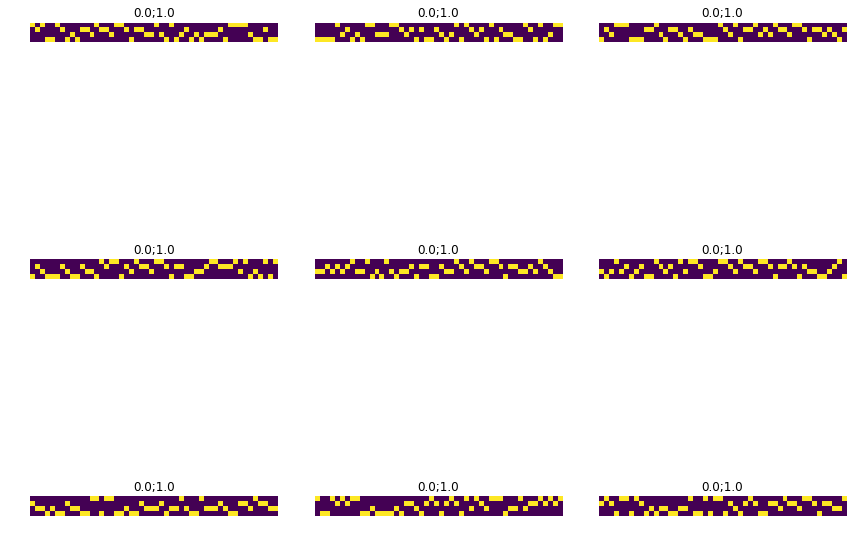

In [29]:
data.show_batch(rows=3)

# Model setup

In [ ]:
## JUST FOR TESTING

In [136]:
test_learn = create_cnn(data, models.resnet34)

In [137]:
test_learn.loss_func

<function torch.nn.functional.binary_cross_entropy_with_logits(input, target, weight=None, size_average=None, reduce=None, reduction='elementwise_mean', pos_weight=None)>

In [138]:
#test_learn.model[0]

In [139]:
test_learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [30]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [31]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [32]:
#def ResizeOutput(): return Lambda(lambda x: x.view(-1))

In [33]:
net = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Linear(in_features=16, out_features=2),
                    #Debugger()
                   )

In [34]:
net

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Linear(in_features=288, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=2, bias=True)
)

In [ ]:
## JUST FOR TESTING

In [35]:
data.train_ds[3]

(Image (1, 4, 50), MultiCategory 0.0;1.0)

In [36]:
data.train_ds[0][0].data.shape

torch.Size([1, 4, 50])

In [37]:
net(data.train_ds[0][0].data)

tensor([[-0.0212, -0.2126]], grad_fn=<ThAddmmBackward>)

# Learner setup

In [38]:
learn = Learner(data, net, loss_func=nn.BCEWithLogitsLoss())#, metrics=accuracy)

In [39]:
learn.summary()

Layer (type)               Output Shape         Param #   
Lambda                    [64, 4, 50]          0                   
________________________________________________________________________________
Conv1d                    [64, 32, 39]         1568                
________________________________________________________________________________
MaxPool1d                 [64, 32, 9]          0                   
________________________________________________________________________________
Lambda                    [64, 288]            0                   
________________________________________________________________________________
Linear                    [64, 16]             4624                
________________________________________________________________________________
ReLU                      [64, 16]             0                   
________________________________________________________________________________
Linear                    [64, 2]              

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


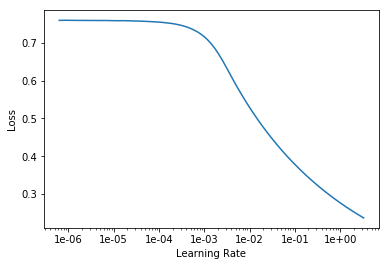

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(15, max_lr=1e-3)

Total time: 00:25
epoch  train_loss  valid_loss
1      0.726247    0.675351    (00:01)
2      0.604617    0.338061    (00:01)
3      0.365617    0.021571    (00:01)
4      0.205116    0.003383    (00:01)
5      0.119641    0.001752    (00:01)
6      0.071585    0.001130    (00:01)
7      0.043498    0.000799    (00:01)
8      0.026702    0.000605    (00:01)
9      0.016518    0.000485    (00:01)
10     0.010292    0.000409    (00:01)
11     0.006465    0.000361    (00:01)
12     0.004106    0.000332    (00:01)
13     0.002649    0.000316    (00:01)
14     0.001749    0.000310    (00:01)
15     0.001195    0.000309    (00:01)



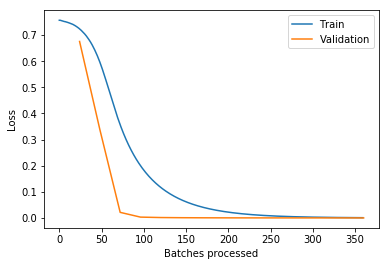

In [42]:
learn.recorder.plot_losses()

In [43]:
learn.validate()#metrics=[accuracy])

[0.000309012]

In [44]:
interpret = ClassificationInterpretation.from_learner(learn)

In [45]:
interpret.confusion_matrix()

RuntimeError: Expected object of scalar type Float but got scalar type Long for argument #2 'other'

In [158]:
%debug

> /Users/MMP/Downloads/fastai/fastai/vision/learner.py(110)confusion_matrix()
    108         "Confusion matrix as an `np.ndarray`."
    109         x=torch.arange(0,self.data.c)
--> 110         if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
    111         else:
    112             cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)

ipdb> x
tensor([0, 1])
ipdb> x.type()
'torch.LongTensor'
ipdb> self.data.c
2
ipdb> x[:,None]
tensor([[0],
        [1]])
ipdb> x[:,None,None]
tensor([[[0]],

        [[1]]])
ipdb> x[:,None].type()
'torch.LongTensor'
ipdb> x[:,None,None].type()
'torch.LongTensor'
ipdb> self.pred_class==x[:,None]
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,